# Inhouse Testing Functions: Development Notebook for Analysis Functions 

Basically, my code scrapbook for generating analysis pipelines.  
**NOTE** there is actually some useful stuff in here, but ideally I will move it all somewhere else.

#### Dependencies 

In [21]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

#### Function definitions 

In [89]:
#############################################################################################
#                        Extract Stage 1: folder path -> list                               #
#############################################################################################

def extract_events(folder_path):
    flist = os.listdir(folder_path) # List of event files
    event_list = []
    for f in flist:
        if f[-4:] == 'json':
            event_list.append(json.load(open(folder_path+f)))
    return event_list

#############################################################################################
#                     Extract Stage 2: event list -> dataframe views                        #
#############################################################################################

def extract_responses(event_list, filter_rt_threshold = 1.2, print_results = False):
    # init output lists
    t_list = []
    rt_list = []
    acc_list = []
    diff_list = []
    completion_list = []
    type_list = []
    cue_list = []
    score_list = []
    userID_list = []
    sessionID_list = []
    index_list = []

    #iterate over events
    for e in event_list:
        # Check if event is a response (keypress, or trial end)
        if e['type'] == 'GoNoGo_TrialEnd':
            # Structs
            d = e['details']
            c = e['context']
            
            if filter_rt_threshold:
                if d['responseTime'] <= filter_rt_threshold:
                    # Append data to appropriate lists
                    t_list.append(e['timeStamp'])
                    rt_list.append(d['responseTime'])
                    acc_list.append(d['success'])
                    type_list.append(d['responseType'])
                    diff_list.append(c['PieceID'])
                    completion_list.append(c['PieceCompletion'])
                    cue_list.append(c['LastCue'])
                    score_list.append(c['Score'])
                    userID_list.append(e['userID'])
                    sessionID_list.append(c['Session'])
                    index_list.append(d['trialIndex'])

    # Need to rethink slightly: the reference time should probably be time of anticipated obstacle, 
    # which could depend on the piece
    resp_df = pd.DataFrame({'trialIdx':index_list, 't':t_list,'rt':rt_list, 'accuracy':acc_list,
                            'difficulty':diff_list,'cue':cue_list,'type':type_list, 
                            '%complete':completion_list, 'score':score_list,
                           'userID':userID_list, 'sessionID':sessionID_list})
    
    # We want to remove the end trials NoResponse for the trialidx with LateResponse
    for trial in resp_df.trialIdx.unique():
        trial_mask = (resp_df['trialIdx'] == trial)
        if sum(trial_mask) > 1: #if more than 1 entry
            nr_mask = (resp_df.type == 'NoResponse')
            resp_df = resp_df[~(trial_mask & nr_mask)]
    #resp_df.reset_index(level=0,inplace=True)
    #resp_df['level_0'] = resp_df.sort_values(by='level_0')['level_0'].values
    #resp_df.set_index('level_0',inplace=True,drop=True,append= True)
    
    resp_df.set_index('trialIdx',inplace=True,drop=False,append= True)
    resp_df.sort_index(level='trialIdx',inplace=True)
    
    return resp_df

def extract_responses_v2(event_list, filter_rt_threshold = 1.2, print_results = False):
    # init output lists
    t_list = []
    rt_list = []
    acc_list = []
    diff_list = []
    completion_list = []
    type_list = []
    cue_list = []
    score_list = []
    userID_list = []
    sessionID_list = []
    index_list = []
    piece_list = []
    #iterate over events
    for e in event_list:
        # Check if event is a response (keypress, or trial end)
        if e['type'] == 'GoNoGo_TrialEnd':
            # Structs
            d = e['details']
            c = e['context']
            
            if filter_rt_threshold:
                if d['responseTime'] <= filter_rt_threshold:
                    # Append data to appropriate lists
                    t_list.append(e['timeStamp']-d['responseTime'])
                    rt_list.append(d['responseTime'])
                    acc_list.append(d['success'])
                    type_list.append(d['responseType'])
                    diff_list.append(c['PieceID'])
                    completion_list.append(c['PieceCompletion']-(d['responseTime']*(c['PieceSequenceIndex']+c['PieceCompletion'])/e['timeStamp']))
                    cue_list.append(c['LastCue'])
                    score_list.append(c['Score'])
                    userID_list.append(e['userID'])
                    sessionID_list.append(c['Session'])
                    index_list.append(d['trialIndex'])
                    piece_list.append(c['PieceSequenceIndex'])

    # Need to rethink slightly: the reference time should probably be time of anticipated obstacle, 
    # which could depend on the piece
    resp_df = pd.DataFrame({'trialIdx':index_list, 't':t_list,'rt':rt_list, 'accuracy':acc_list,
                            'difficulty':diff_list,'cue':cue_list,'type':type_list, 'piece':piece_list,
                            '%complete':completion_list, 'score':score_list,
                           'userID':userID_list, 'sessionID':sessionID_list})
    
    # We want to remove the end trials NoResponse for the trialidx with LateResponse
    for trial in resp_df.trialIdx.unique():
        trial_mask = (resp_df['trialIdx'] == trial)
        if sum(trial_mask) > 1: #if more than 1 entry
            nr_mask = (resp_df.type == 'NoResponse')
            resp_df = resp_df[~(trial_mask & nr_mask)]
    #resp_df.reset_index(level=0,inplace=True)
    #resp_df['level_0'] = resp_df.sort_values(by='level_0')['level_0'].values
    #resp_df.set_index('level_0',inplace=True,drop=True,append= True)
    
    resp_df.set_index('trialIdx',inplace=True,drop=False,append= True)
    resp_df.sort_index(level='trialIdx',inplace=True)
    
    return resp_df

def extract_collisions(event_list):
    coll_times = []
    coll_where = []
    coll_complet =[]
    coll_type = []
    coll_score = []
    for e in event_list:
        if e['type'] == 'Driving_Crash':
            c = e['context']
            d = e['details']
            coll_times.append(e['timeStamp'])
            coll_where.append(c['PieceID'])
            coll_complet.append(c['PieceCompletion'])
            coll_type.append(d['CollisionType'])
            coll_score.append(c['Score'])
    coll_df = pd.DataFrame({'t':coll_times,'piece':coll_where,'%complete':coll_complet, 'type':coll_type, 'score':coll_score})
    coll_df.set_index('t',inplace=True,drop=False,append=True)
    coll_df = coll_df.sort_index(level='t')
    return coll_df

def extract_collections(event_list):
    coll_times = []
    coll_where = []
    coll_complet =[]
    for e in event_list:
        if e['type'] == 'Driving_CollectibleCollected':
            c = e['context']
            coll_times.append(e['timeStamp'])
            coll_where.append(c['PieceID'])
            coll_complet.append(c['PieceCompletion'])
    coll_df = pd.DataFrame({'t':coll_times,'piece':coll_where,'%complete':coll_complet})
    coll_df.set_index('t',inplace=True,drop=False,append=True)
    coll_df = coll_df.sort_index(level='t')
    return coll_df

def extract_context(event_list):
    t_list = []
    seqID = []
    session = []
    pieceID = []
    pieceIdx = []
    for e in event_list:
        if e['type'] == 'Driving_BeginChunk':
            c = e['context']
            t_list.append(e['timeStamp'])
            seqID.append(c['SequenceID'])
            pieceID.append(c['PieceID'])
            pieceIdx.append(c['PieceSequenceIndex'])
            session.append(c['Session'])
    context_df = pd.DataFrame({'Session':session, 'SeqID':seqID, 'PieceID':pieceID, 'PieceIdx':pieceIdx, 't':t_list})
    context_df.set_index('PieceIdx',inplace=True,drop=False)
    context_df = context_df.sort_index(level='PieceIdx')
    return context_df

#######################################################################################################################
#                                   Stage 2.5: View manipulation functions                                            #
#######################################################################################################################

def df_add_rounded(df,t=True,rt = True,complete=True, decimals = [1,1,-1]):
    if t:
        df['round_%'] = np.round(df['%complete'],decimals[0])
    if rt:
        df['round_rt'] = np.round(df['rt'],decimals=decimals[1])
    if complete:
        df['round_t'] = np.round(df['t'],decimals = decimals[2])
    return df

def filter_probes(df, nulls = ['Blank', 'Cue Easy', 'Cue Hard', 'Cue Random']):
    filtered_df = df.copy()
    null_mask = filtered_df['difficulty'].isin(nulls)
    filtered_df = filtered_df[~null_mask]
    return filtered_df

####################################################################################################
#                         Extract Stage 3: DF views -> results and vis                             #
####################################################################################################

def session_summary(session_path, filter_rt_threshold = 1.2, save_figures=False, session_title= 'test', print_results=True):
    # Input: path to session folder to be summarized
    
    # Convert json -> Tabular formats
    event_list = extract_events(session_path) # take events in json and create a list of the json-like entries
    response_df = extract_responses_v2(event_list, filter_rt_threshold = filter_rt_threshold, print_results = False) # convert response event into tabular format
    collision_df = extract_collisions(event_list) # collisions into tabular format
    
    # SUMMARY: Collisions
    n_collisions = collision_df.shape[0]
    if print_results:
        print('This session contains ', n_collisions, ' collisions.')
    
    # SUMMARY: Score
    max_score = response_df.score.max()
    if print_results:
        print('The max score for this session is: ', max_score, ' points.')
    
    # SUMMARY: Overall Speed/Acc.
    response_mask = response_df['type'].isin(['KeyPress_InsideWindow','KeyPress_OutsideWindow'])
    mean_accuracy = response_df[response_mask].accuracy.mean()
    median_rt = response_df[response_mask].rt.median()
    
    if print_results:
        print('This session\'s accuracy is: ', mean_accuracy*100, '%.')
        print('This session\'s median response time is: ', median_rt*1000, ' ms.')
    
    response_df = df_add_rounded(response_df, t = True, rt = True, complete = True, decimals = [1,1,-1])  # round some values for grouping
    filtered_response_df = filter_probes(response_df) # Create a df for responses within the easy/hard segments
    
    
    ###################################################################################################################
    #                                         SUMMARY: RESPONSE TIMES                                                 #
    ###################################################################################################################
        
    if print_results:
        
        # SUMMARY PLOT: Response Time Overall
        plt.figure();
        rt_plot = filtered_response_df.rt.plot(kind='hist');
        plt.xlabel('Response Time (s)');
        plt.title('Overall Response Time');
        if save_figures:
            plt.savefig(session_title+'_session_overall_rt.png');
        
        rt_plot
        # SUMMARY PLOT: Response Time x Difficulty Condition

        difficulty_view = filtered_response_df.groupby('difficulty')
        plt.figure();
        rt_bydifficulty_plot = difficulty_view.rt.median().plot(kind = 'bar');
        plt.ylabel('Median Response Time');
        plt.title('Response Time x Difficulty Condition');
        if save_figures:
            plt.savefig(session_title + '_session_rt-bydifficulty.png')
        
        rt_bydifficulty_plot
        
        # SUMMARY PLOT: Response Time x Cue Condition
        cue_view = filtered_response_df.groupby('cue')
        plt.figure();
        rt_bycue_plot = cue_view.rt.median().plot(kind = 'bar');
        plt.ylabel('Median Response Time');
        plt.title('Response Time x Cue Condition')
        if save_figures:
            plt.savefig(session_title + '_session_rt-bycue.png')
            
        rt_bycue_plot

        # SUMMARY PLOT: Response Time x (Difficulty & Cue) Condition
        grid_view = filtered_response_df.groupby(['cue','difficulty'])
        plt.figure();
        rt_bybothconditions_plot = grid_view.rt.median().plot(kind = 'bar');
        plt.ylabel('Median Response Time')
        plt.title('Response Time x (Difficulty & Cue)')
        if save_figures:
            plt.savefig(session_title + '_session_rt-byboth.png')
        
        rt_bybothconditions_plot

        ###################################################################################################################
        #                                           SUMMARY: Accuracy                                                     #
        ###################################################################################################################

        # SUMMARY PLOT: Accuracy x Difficulty Condition
        plt.figure();
        acc_bydifficulty_plot = difficulty_view.accuracy.mean().plot(kind = 'bar');
        plt.ylabel('Mean Accuracy');
        plt.title('Accuracy x Difficulty Condition');
        if save_figures:
            plt.savefig(session_title + '_session_accuracy-bydifficulty.png')
        
        acc_bydifficulty_plot

        # SUMMARY PLOT: Accuracy x Cue Condition
        plt.figure();
        acc_bycue_plot = cue_view.accuracy.mean().plot(kind = 'bar');
        plt.ylabel('Mean Accuracy');
        plt.title('Accuracy x Cue Condition')
        if save_figures:
            plt.savefig(session_title + '_session_accuracy-bycue.png')
        
        acc_bycue_plot

        # SUMMARY PLOT: Response Time x (Difficulty & Cue) Condition
        plt.figure();
        acc_bybothconditions_plot = grid_view.accuracy.mean().plot(kind = 'bar');
        plt.ylabel('Mean Accuracy')
        plt.title('Accuracy x (Difficulty & Cue)')
        if save_figures:
            plt.savefig(session_title + '_session_accuracy-byboth.png')
        
        acc_bybothconditions_plot
        
    return filtered_response_df, response_df, collision_df, n_collisions, max_score
#rt_plot,  rt_bydifficulty_plot, rt_bycue_plot, rt_bybothconditions_plot, acc_bydifficulty_plot, acc_bycue_plot, acc_bybothconditions_plot

#######################################################################################################################
#                                   Stage 4: Multi-Session Analyses                                                   #
#######################################################################################################################

def multi_session_summary(player_folder, filter_rt_threshold = 1.2, print_results = True, save_figures = False, player_title='TestSubject'):
    # init output
    collisions_per_session = []
    max_score_per_session = []
    all_responses = pd.DataFrame()
    all_filtered_responses = pd.DataFrame()
    
    # iterate over sessions, extract data
    for f in os.listdir(player_folder):
        filtered_response_df, response_df, collision_df, n_collisions, max_score = session_summary(player_folder+f+'\\', 
                                                                                                   filter_rt_threshold=filter_rt_threshold, 
                                                                                                   print_results=False)
        collisions_per_session.append(n_collisions)
        max_score_per_session.append(max_score)
        all_responses = all_responses.append(response_df)
        all_filtered_responses = all_filtered_responses.append(filtered_response_df)
        
    # compute summary statistics
    mean_collisions = np.mean(collisions_per_session)
    std_collisions = np.std(collisions_per_session)
    
    mean_max_score = np.mean(max_score_per_session)
    std_max_score = np.std(max_score_per_session)
    
    # print outputs
    if print_results:
        print('This player averages', mean_collisions, 'collisions per session (std = ', np.round(std_collisions,decimals=2),').')
        print('This player averages', mean_max_score, 'max score per session (std = ', np.round(std_max_score,decimals=0),').')
        
    # figures
        ###########################################################################################################################
        #                                        PLAYER SUMMARY: ACCURACY                                                         #
        ###########################################################################################################################
        
        
        
        #####################  CONDITION : DIFFICULTY
        
        # Accuracy by difficulty, plotted over course of segment
        difficulty_view = all_filtered_responses.groupby(['difficulty','round_%'])
        ts = difficulty_view.accuracy.mean()
        tssem = difficulty_view.accuracy.sem()
        ts.unstack(level=0).plot(yerr=tssem.unstack(level=0));
        plt.ylabel('Accuracy');
        plt.title('Accuracy x Difficulty over % Segment Completion');
        if save_figures:
            plt.savefig(player_title + '_accuracy-bydifficulty.png');
        
        
            
        # RT by difficulty
        ts2 = difficulty_view.rt.median()
        ts2sem = difficulty_view.rt.sem()
        ts2.unstack(level=0).plot(yerr=ts2sem.unstack(level=0));
        plt.ylabel('Median RT');
        plt.title('RTx Difficulty over % Segment Completion');
        if save_figures:
            plt.savefig(player_title + '_rt-bydifficulty.png');
            
        #####################  CONDITION : CUE
        
        # Accuracy by cue, plotted over the course of segment
        cue_view = all_filtered_responses.groupby(['cue','round_%'])
        ts_cue = cue_view.accuracy.mean()
        ts_cue_sem = cue_view.accuracy.sem()
        ts_cue.unstack(level=0).plot(yerr=ts_cue_sem.unstack(level=0));
        plt.ylabel('Accuracy');
        plt.title('Accuracy x Cue over % Segment Completion');
        if save_figures:
            plt.savefig(player_title + '_accuracy-bycue.png')
        
        # RT by cue
        ts_cue2 = cue_view.rt.median()
        ts_cue2_sem = cue_view.rt.sem()
        ts_cue2.unstack(level=0).plot(yerr=ts_cue2_sem.unstack(level=0));
        plt.ylabel('Median RT');
        plt.title('RTx Cue over % Segment Completion');
        if save_figures:
            plt.savefig(player_title + '_rt-bycue.png');
        
        #####################  CONDITION : DIFFICULTY & CUE
        
        # Accuracy by difficulty and cue, plotted over the course of segment
        grid_view = all_filtered_responses.groupby(['difficulty','cue','round_%'])
        ts_grid = grid_view.accuracy.mean()
        ts_grid_sem = grid_view.accuracy.sem()
        ts_grid.unstack(level=1).unstack(level=0).plot(yerr=ts_grid_sem.unstack(level=1).unstack(level=0),figsize=(9,6));
        plt.ylabel('Accuracy');
        plt.title('Accuracy x (Difficulty & Cue)');
        if save_figures:
            plt.savefig(player_title + '_accuracy-bygrid.png')
        
        ####### Currently, this plot has legend entries for cue-test combinations which do not exist.
        # It will take a good bit of finagling to resolve this
        # One possible solution: Take multi-index pairs and rewrite them as one index entry. 
        # source: https://stackoverflow.com/questions/31845258/pandas-multi-index-plotting answer #2
        
        # RT by difficulty and cue
        ts_grid2 = grid_view.rt.median()
        ts_grid2_sem = grid_view.rt.sem()
        ts_grid2.unstack(level=1).unstack(level=0).plot(yerr=ts_grid2_sem.unstack(level=1).unstack(level=0),figsize=(12,9));
        plt.ylabel('Median RT');
        plt.title('RTx (Difficulty & Cue)');
        if save_figures:
            plt.savefig(player_title + '_rt-bygrid.png');
            
    #outputs
    collision_summary = [mean_collisions,std_collisions]
    score_summary = [mean_max_score, std_max_score]
    
    return collision_summary, score_summary, all_filtered_responses, all_responses

#######################################################################################################################
#                                            Stage 5: Group Analysis                                                  #
#######################################################################################################################
def group_response_summary(training_game_data_folder):
    
    player_folders = os.listdir(training_game_data_folder)
    full_filtered_responses = pd.DataFrame()
    
    for player_folder in player_folders:
        collision_summary, score_summary, all_filtered_responses, all_responses = multi_session_summary(player_folder, 
                                                                                                        filter_rt_threshold = 1.2, 
                                                                                                        print_results = False, 
                                                                                                        save_figures = False, 
                                                                                                        player_title='TestSubject')
        full_filtered_responses.append(all_filtered_responses)
    return full_filtered_responses
        
            

#### Pathing

In [70]:
# Folder name
#game_saves_path =  'C:\\Users\\flemm053\\Documents\\research\\ULALA\\Games\\ResourceAllocationGame\\V2p1\\WindowsBuild\\TrainingGame_Data\\GameplayData\\'
game_saves_path = 'C:\\Users\\flemm053\\Documents\\research\\ULALA\\Games\\ResourceAllocationGame\\V3p1\\WindowsBuild\\TrainingGame_Data\\GameplayData\\me\\'
folders = os.listdir(game_saves_path)
# folder = 'Default Player Name_2019_08_20___16_11_11'
# r1 = 'RMFtest1_2019_08_21___10_44_51\\'
# r2 = 'RMFtest2_2019_08_21___13_55_02\\'
# r3 = 'RMFtest3_2019_08_21___16_14_15\\'
# e1 = 'EStest1_2019_08_21___13_39_03\\'

# # event types
# probe_on = 'GoNoGo_On'
# probe_start = 'GoNoGo_TrialStart'
# probe_off = 'GoNoGo_Off'
# probe_end = 'GoNoGo_TrialEnd'

# chunk_on = 'Driving_BeginChunk'
# collection = 'Driving_CollectibleCollected'
# crash = 'Driving_Crash'

# # file type
# ext = '.json'

In [81]:
# Small scale testing utilities
event_list = extract_events(game_saves_path+folders[3]+'//')
df = extract_responses(event_list)
df.set_index('trialIdx',inplace=True,drop=False,append= False)
df.sort_index(level='trialIdx',inplace=True)

In [92]:
event_list[7]

{'timeStamp': 102.1958,
 'userID': 'Manu',
 'type': 'GoNoGo_TrialEnd',
 'details': {'trialIndex': 45,
  'success': True,
  'responseType': 'KeyPress_InsideWindow',
  'responseTime': 0.256164551},
 'context': {'Version': '3.1',
  'Session': 'Manu_3.1_2019_08_26___19_17_33',
  'Difficulty': '3',
  'SequenceID': 280,
  'PieceID': 'Cue Random',
  'PieceSequenceIndex': 43,
  'PieceCompletion': 0.426432282,
  'LastCue': 'Cue_Random',
  'Score': 2039.0,
  'FPS': 702}}

## Level 1: Individual Session Summaries

In [73]:
response_df['trialIdx'].max()

62

In [93]:
response_df.head()

trialIdx          t        rt  accuracy  difficulty         cue  \
   trialIdx                                                                    
57 0                0   8.611301  0.423309      True       Blank    Cue_Hard   
6  1                1  10.806001  0.357697      True    Cue Hard    Cue_Hard   
17 2                2  12.932335  0.600189     False      Hard_B    Cue_Hard   
19 3                3  15.283164  0.280212      True       Blank    Cue_Hard   
20 4                4  17.551830  0.300751      True  Cue Random  Cue_Random   

                              type  piece  %complete  score userID  \
   trialIdx                                                          
57 0         KeyPress_InsideWindow      3   0.608562  268.0   Manu   
6  1         KeyPress_InsideWindow      4   0.547879  522.0   Manu   
17 2                    NoResponse      5   0.460240  276.0   Manu   
19 3         KeyPress_InsideWindow      6   0.465486  531.0   Manu   
20 4         KeyPress_InsideWindow      7   0.437686  785.0   Manu   

                                  sessionID  round_%  round_rt  round_t  
   trialIdx                                                              
57 0         Manu_3.1_2019_08_26___18_23_13      0.6       0.4     10.0  
6  1         Manu_3.1_2019_08_26___18_23_13      0.5       0.4     10.0  
17 2         Manu_3.1_2019_08_26___18_23_13      0.5       0.6     10.0  
19 3         Manu_3.1_2019_08_26___18_23_13      0.5       0.3     20.0  
20 4         Manu_3.1_2019_08_26___18_23_13      0.4       0.3     20.0

In [80]:
(response_df.piece.max()) / 3

18.333333333333332

This session contains  0  collisions.
The max score for this session is:  12260.0  points.
This session's accuracy is:  98.24561403508771 %.
This session's median response time is:  302.520752  ms.


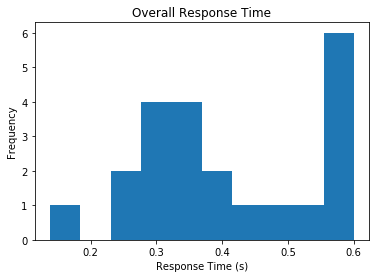

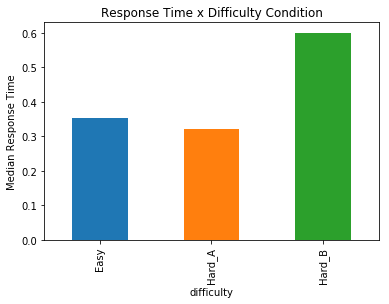

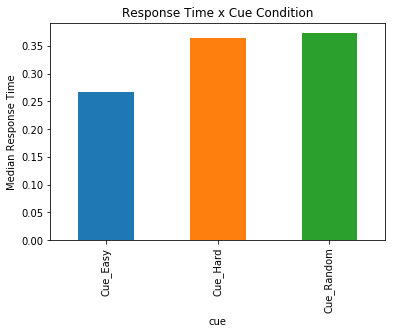

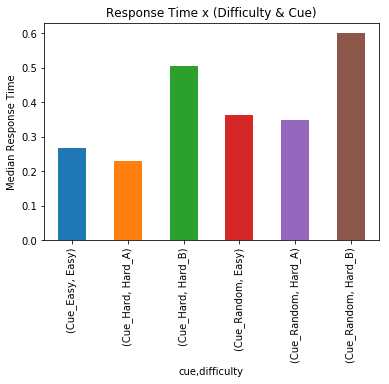

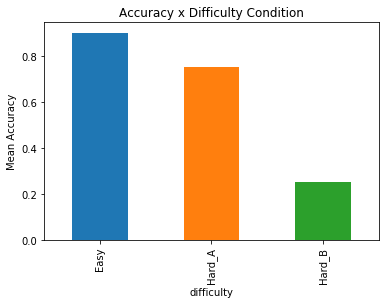

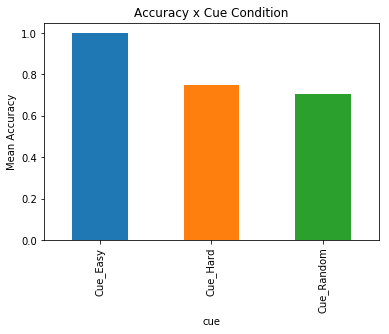

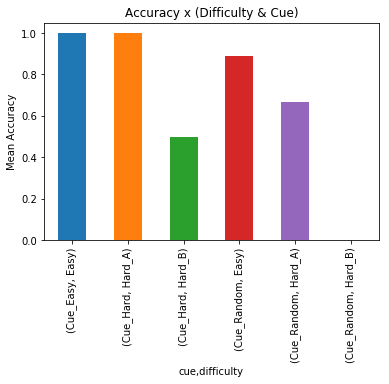

In [71]:
filtered_response_df, response_df, collision_df, n_collisions, max_score = session_summary(game_saves_path+folders[1]+'//',print_results=True);

## Level 2: Player Profile Summaries (Multiple Sessions) 

This player averages 0.7692307692307693 collisions per session (std =  1.05 ).
This player averages 9690.461538461539 max score per session (std =  2347.0 ).


C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


KeyError: 'Column not found: True'

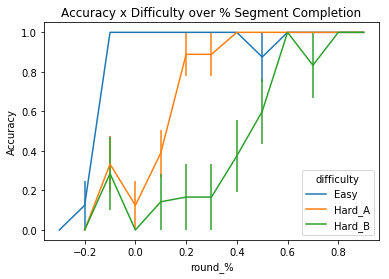

In [90]:
c_summ, ms_summ,all_fdf,all_df = multi_session_summary(game_saves_path, filter_rt_threshold = 1.05,
                                                       print_results = True, save_figures = False,
                                                       player_title='TestSubject')

C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
C:\Users\flemm053\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: UserWarning: Warning: 

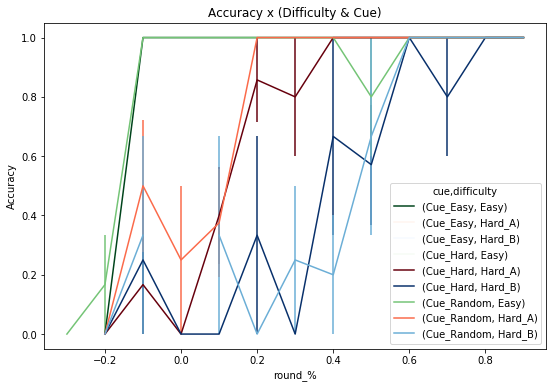

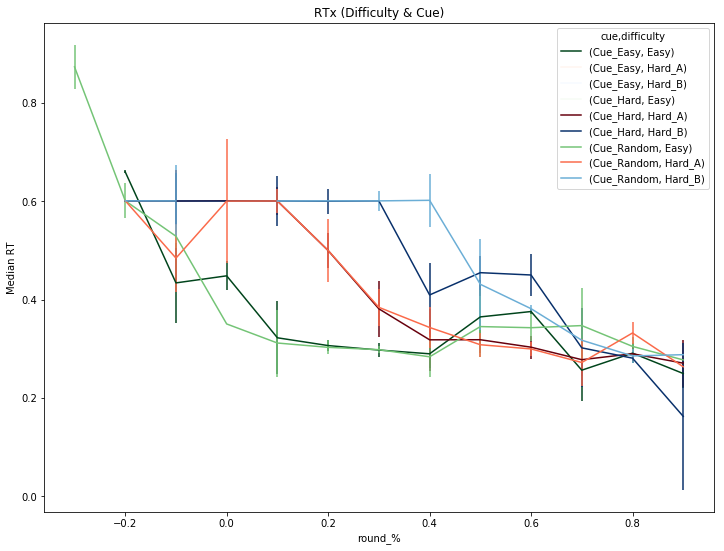

In [85]:
greens = cm.get_cmap('Greens',3)
cue_easy_cmap = greens(np.array([1,.5,0]))
reds = cm.get_cmap('Reds',3)
cue_hard_cmap = reds(np.array([0,.4,.75]))
oranges = cm.get_cmap('Blues',3)
cue_rand_cmap = oranges(np.array([0,.5,.8]))
virdis = cm.get_cmap('viridis',9)
condition_cmap = virdis(np.linspace(0,1,9))
condition_cmap[:3,:] = cue_easy_cmap
condition_cmap[3:6,:] = cue_hard_cmap
condition_cmap[6:,:] = cue_rand_cmap
condition_cmap = np.array([cue_easy_cmap[0,:],cue_hard_cmap[0,:],cue_rand_cmap[0,:],cue_easy_cmap[2,:],cue_hard_cmap[2,:],cue_rand_cmap[2,:],
                           cue_easy_cmap[1,:],cue_hard_cmap[1,:],cue_rand_cmap[1,:]])
condition_cmap = ListedColormap(condition_cmap)
grid_view = all_fdf.groupby(['difficulty','cue','round_%'])
ts_grid = grid_view.accuracy.mean()
ts_grid_sem = grid_view.accuracy.sem()
ts_grid.unstack(level=1).unstack(level=0).plot(yerr=ts_grid_sem.unstack(level=1).unstack(level=0),figsize=(9,6),cmap=condition_cmap);
plt.ylabel('Accuracy');
plt.title('Accuracy x (Difficulty & Cue)');

####### Currently, this plot has legend entries for cue-test combinations which do not exist.
# It will take a good bit of finagling to resolve this
# One possible solution: Take multi-index pairs and rewrite them as one index entry. 
# source: https://stackoverflow.com/questions/31845258/pandas-multi-index-plotting answer #2

# RT by difficulty and cue
ts_grid2 = grid_view.rt.median()
ts_grid2_sem = grid_view.rt.sem()
ts_grid2.unstack(level=1).unstack(level=0).plot(yerr=ts_grid2_sem.unstack(level=1).unstack(level=0),figsize=(12,9),cmap=condition_cmap);
plt.ylabel('Median RT');
plt.title('RTx (Difficulty & Cue)');

In [47]:
x = grid_view.rt.median()
xlabels = x.index.values

In [48]:
# for i in range(len(xlabels)):
#     dif = xlabels[i][0]
#     cue = xlabels[i][1]
#     perc = xlabels[i][2]
#     print('Difficulty:',dif,', Cue:',cue, ', Round_%: ',perc)

In [66]:
all_fdf.head()

trialIdx          t        rt  accuracy difficulty         cue  \
   trialIdx                                                                   
13 3                3  12.420455  0.380892      True       Easy  Cue_Random   
22 7                7  19.617765  0.320412      True       Easy  Cue_Random   
26 11              11  26.996439  0.318337      True     Hard_A    Cue_Hard   
29 14              14  33.139454  0.601139     False     Hard_A  Cue_Random   
32 17              17  39.679712  0.260338      True     Hard_A  Cue_Random   

                              type  piece  %complete   score userID  \
   trialIdx                                                           
13 3         KeyPress_InsideWindow      5   0.232980   525.0   Manu   
22 7         KeyPress_InsideWindow      8   0.316300  1539.0   Manu   
26 11        KeyPress_InsideWindow     11   0.478052  2554.0   Manu   
29 14                   NoResponse     14   0.111236  2817.0   Manu   
32 17        KeyPress_InsideWindow     17  -0.086869  3579.0   Manu   

                                  sessionID  round_%  round_rt  round_t  
   trialIdx                                                              
13 3         Manu_3.1_2019_08_26___18_17_10      0.2       0.4     10.0  
22 7         Manu_3.1_2019_08_26___18_17_10      0.3       0.3     20.0  
26 11        Manu_3.1_2019_08_26___18_17_10      0.5       0.3     30.0  
29 14        Manu_3.1_2019_08_26___18_17_10      0.1       0.6     30.0  
32 17        Manu_3.1_2019_08_26___18_17_10     -0.1       0.3     40.0

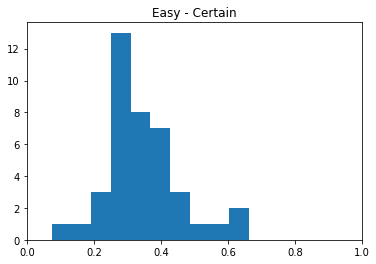

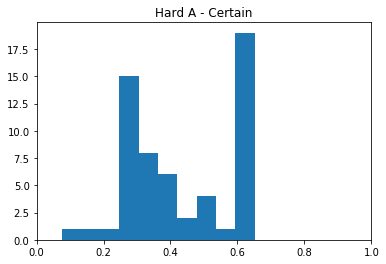

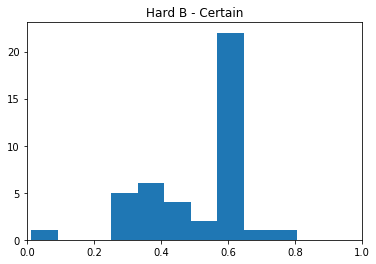

In [65]:
plt.figure();
plt.hist(all_fdf[(all_fdf.cue == 'Cue_Easy') & (all_fdf.difficulty == 'Easy')].rt);
plt.xlim([0,1.]);
plt.title('Easy - Certain');

plt.figure();
plt.hist(all_fdf[(all_fdf.cue == 'Cue_Hard') & (all_fdf.difficulty == 'Hard_A')].rt);
plt.xlim([0,1.]);
plt.title('Hard A - Certain');

plt.figure();
plt.hist(all_fdf[(all_fdf.cue == 'Cue_Hard') & (all_fdf.difficulty == 'Hard_B')].rt);
plt.xlim([0,1.]);
plt.title('Hard B - Certain');

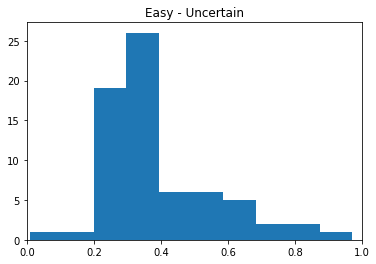

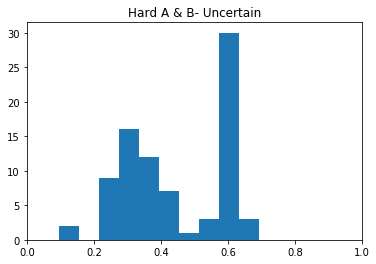

In [67]:
plt.figure();
plt.hist(all_fdf[(all_fdf.cue == 'Cue_Random') & (all_fdf.difficulty == 'Easy')].rt);
plt.xlim([0,1.]);
plt.title('Easy - Uncertain');

plt.figure();
plt.hist(all_fdf[(all_fdf.cue == 'Cue_Random') & (all_fdf.difficulty != 'Easy')].rt);
plt.xlim([0,1.]);
plt.title('Hard A & B- Uncertain');

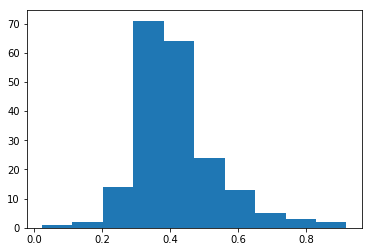

In [51]:
plt.hist(all_fdf.rt);

In [52]:
import seaborn as sns

C:\Users\flemm053\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


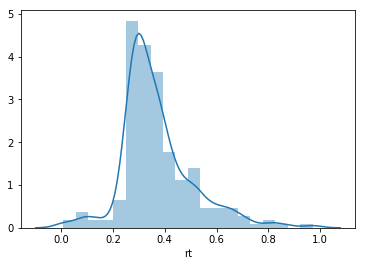

In [88]:
sns.distplot(all_fdf[all_fdf.type != 'NoResponse'].rt,bins=20);

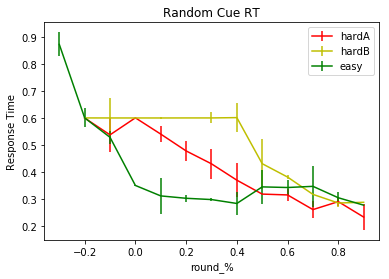

In [60]:
hardA_uncertain = all_fdf[(all_fdf.difficulty == 'Hard_A') & (all_fdf.cue == 'Cue_Random')]
hardB_uncertain = all_fdf[(all_fdf.difficulty == 'Hard_B') & (all_fdf.cue == 'Cue_Random')]
easy_uncertain = all_fdf[(all_fdf.difficulty == 'Easy') & (all_fdf.cue == 'Cue_Random')]
hardA_certain = all_fdf[(all_fdf.difficulty == 'Hard_A') & (all_fdf.cue == 'Cue_Hard')]
hardB_certain = all_fdf[(all_fdf.difficulty == 'Hard_B') & (all_fdf.cue == 'Cue_Hard')]
easy_certain = all_fdf[(all_fdf.difficulty == 'Easy') & (all_fdf.cue == 'Cue_Easy')]

hardA_certain.groupby('round_%').rt.mean().plot(yerr=hardA_certain.groupby('round_%').rt.sem(),color='r');
hardB_uncertain.groupby('round_%').rt.median().plot(yerr=hardB_uncertain.groupby('round_%').rt.sem(),color='y');
easy_uncertain.groupby('round_%').rt.median().plot(yerr=easy_uncertain.groupby('round_%').rt.sem(),color='g');
plt.legend(['hardA','hardB','easy']);
plt.title('Random Cue RT');
plt.ylabel('Response Time');

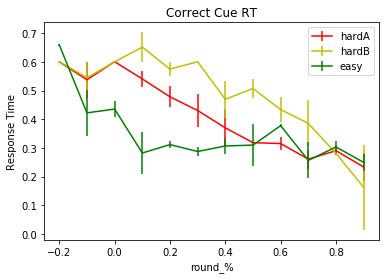

In [61]:
hardA_certain.groupby('round_%').rt.mean().plot(yerr=hardA_certain.groupby('round_%').rt.sem(),color='r');
hardB_certain.groupby('round_%').rt.mean().plot(yerr=hardB_certain.groupby('round_%').rt.sem(),color='y');
easy_certain.groupby('round_%').rt.mean().plot(yerr=easy_certain.groupby('round_%').rt.sem(),color='g');
plt.legend(['hardA','hardB','easy']);
plt.title('Correct Cue RT');
plt.ylabel('Response Time');

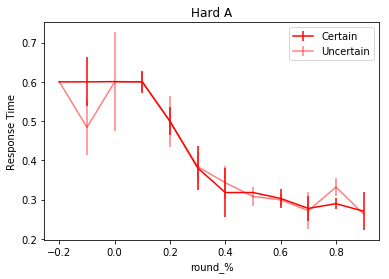

In [87]:
hardA_certain.groupby('round_%').rt.median().plot(yerr=hardA_certain.groupby('round_%').rt.sem(),color='r');
hardA_uncertain.groupby('round_%').rt.median().plot(yerr=hardA_uncertain.groupby('round_%').rt.sem(),color='r',alpha=.5);
plt.legend(['Certain','Uncertain']);
plt.ylabel('Response Time');
plt.title('Hard A');

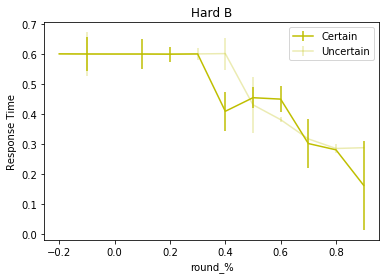

In [63]:
hardB_certain.groupby('round_%').rt.median().plot(yerr=hardB_certain.groupby('round_%').rt.sem(),color='y');
hardB_uncertain.groupby('round_%').rt.median().plot(yerr=hardB_uncertain.groupby('round_%').rt.sem(),color='y',alpha=.3);
plt.legend(['Certain','Uncertain']);
plt.title('Hard B');
plt.ylabel('Response Time');

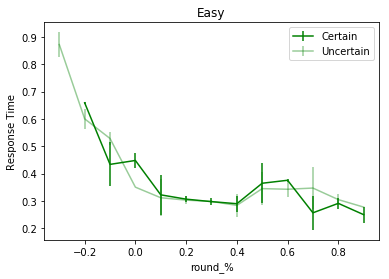

In [64]:
easy_certain.groupby('round_%').rt.median().plot(yerr=easy_certain.groupby('round_%').rt.sem(),color='g');
easy_uncertain.groupby('round_%').rt.median().plot(yerr=easy_uncertain.groupby('round_%').rt.sem(),color='g',alpha=.4);
plt.legend(['Certain','Uncertain']);
plt.title('Easy');
plt.ylabel('Response Time');